<a href="https://colab.research.google.com/github/pratyushagrawal77/GANs/blob/main/Pratyush_077.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pratyush Agrawal
22070126077
AIML-A3

Github:https://github.com/pratyushagrawal77/GANs/tree/main

## `DCGAN` model on `Celeba` Dataset

### DCGAN and CelebA Summary

**DCGAN** (Deep Convolutional GAN) is a type of Generative Adversarial Network that uses convolutional layers to generate realistic images. It consists of two networks: a Generator that creates images from random noise and a Discriminator that distinguishes real images from generated ones.

**CelebA** is a large-scale dataset containing over 200,000 celebrity face images with rich annotations. It is widely used for training and benchmarking models in tasks like face synthesis and recognition.

**DCGAN Architecture**

![DCGAN Architecture](./DCGAN%20Architecture.png)

### Importing Necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image

### Setting up parameters

In [ ]:
# Set random seed for reproducibility
manualSeed = 999
print("Seed: ", manualSeed)
torch.manual_seed(manualSeed)

# Configuration parameters for the DCGAN model
dataroot = "./data/celeba"   # Dataset root directory
image_size = 64              # Image size
batch_size = 128             # Batch size
workers = 2                  # Number of dataloader workers
nz = 100                     # Latent vector size
ngf = 64                     # Generator feature map size
ndf = 64                     # Discriminator feature map size
nc = 3                       # Number of image channels (RGB)
num_epochs = 5               # Number of epochs
lr = 0.0002                  # Learning rate
beta1 = 0.5                  # Adam optimizer beta1

Seed:  999


### Loading and transforming the dataset images and loading the model on `cuda`

In [ ]:
# Device configuration: use GPU if available, else CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define image transformations
transform = transforms.Compose([
    transforms.CenterCrop(178),  # Center crop the images
    transforms.Resize(image_size),  # Resize images to the defined size
    transforms.ToTensor(),  # Convert images to tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize images
])

# Load the CelebA dataset
dataset = dset.CelebA(root=dataroot, split='train', download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=workers)

# Initialize weights for the network
def weights_init(m):
    classname = m.__class__.__name__
    if "Conv" in classname:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif "BatchNorm" in classname:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Defining our `DCGAN` model

In [ ]:
# Define the Generator network
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # First layer
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # Second layer
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Third layer
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Fourth layer
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Output layer
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()  # Output values between -1 and 1
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator network
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # First layer
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Second layer
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Third layer
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Fourth layer
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # Output layer
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Output is a probability
        )

    def forward(self, input):
        return self.main(input).view(-1)


### Initializing the `DCGAN` Genetaor and Discriminator and defining optimizers

In [ ]:
# Initialize the Generator and apply weights
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

# Initialize the Discriminator and apply weights
netD = Discriminator().to(device)
netD.apply(weights_init)
print(netD)

# Define the loss function
criterion = nn.BCELoss()

# Define optimizers for both Generator and Discriminator
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

# Create fixed noise for generating images
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Lists to keep track of losses and generated images
G_losses = []
D_losses = []
img_list = []

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Training the model using a `DCGAN` training loop

In [ ]:
print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator with real images
        netD.zero_grad()
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        label = torch.full((b_size,), 1., dtype=torch.float, device=device)
        output = netD(real_images)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Update Discriminator with fake images
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        label.fill_(0.)
        output = netD(fake_images.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        # Update Discriminator
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(1.)
        output = netD(fake_images)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # Save losses
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Print training statistics every 50 batches
        if i % 50 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}]\t"
                  f"Loss_D: {errD.item():.4f}\tLoss_G: {errG.item():.4f}\t"
                  f"D(x): {D_x:.4f}\tD(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

    # Save generated images after each epoch
    with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
    os.makedirs("results", exist_ok=True)
    vutils.save_image(fake, f"results/fake_samples_epoch_{epoch+1}.png", normalize=True)

print("Training complete!")


Starting Training Loop...
[1/5][0/1272]	Loss_D: 1.7208	Loss_G: 6.9103	D(x): 0.7373	D(G(z)): 0.6777/0.0018
[1/5][50/1272]	Loss_D: 0.1749	Loss_G: 14.8780	D(x): 0.9075	D(G(z)): 0.0000/0.0000
[1/5][100/1272]	Loss_D: 0.1444	Loss_G: 5.3601	D(x): 0.9373	D(G(z)): 0.0208/0.0123
[1/5][150/1272]	Loss_D: 0.3698	Loss_G: 4.1307	D(x): 0.8551	D(G(z)): 0.1274/0.0311
[1/5][200/1272]	Loss_D: 1.4693	Loss_G: 3.4647	D(x): 0.3503	D(G(z)): 0.0040/0.0592
[1/5][250/1272]	Loss_D: 1.5427	Loss_G: 10.0455	D(x): 0.9488	D(G(z)): 0.6526/0.0002
[1/5][300/1272]	Loss_D: 0.6107	Loss_G: 3.8844	D(x): 0.6680	D(G(z)): 0.0423/0.0382
[1/5][350/1272]	Loss_D: 1.2927	Loss_G: 2.0822	D(x): 0.3985	D(G(z)): 0.0072/0.1873
[1/5][400/1272]	Loss_D: 0.8875	Loss_G: 2.6484	D(x): 0.5851	D(G(z)): 0.0253/0.1222
[1/5][450/1272]	Loss_D: 0.8183	Loss_G: 2.7899	D(x): 0.6390	D(G(z)): 0.1767/0.0888
[1/5][500/1272]	Loss_D: 1.0205	Loss_G: 12.1548	D(x): 0.9607	D(G(z)): 0.5508/0.0001
[1/5][550/1272]	Loss_D: 0.5504	Loss_G: 8.4802	D(x): 0.8977	D(G(z)): 0.29

### Visualizing the Generator and Discriminator loss

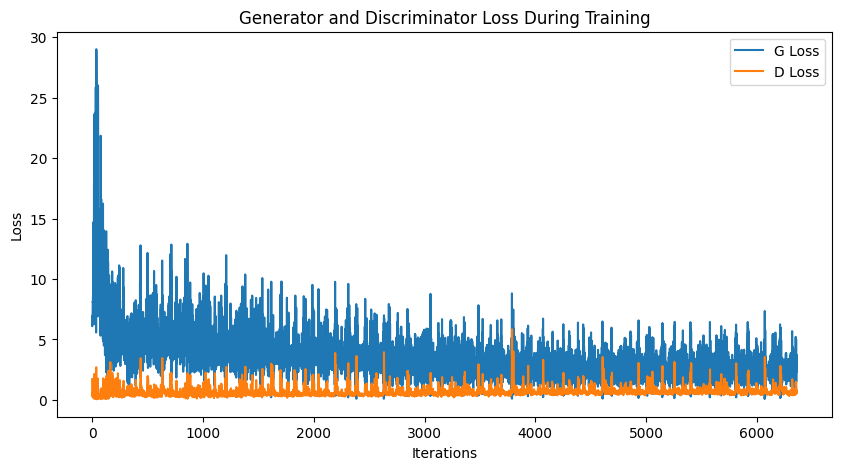

In [ ]:
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G Loss")
plt.plot(D_losses, label="D Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Visualizing the Generated output from the `DCGAN` model

In [ ]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

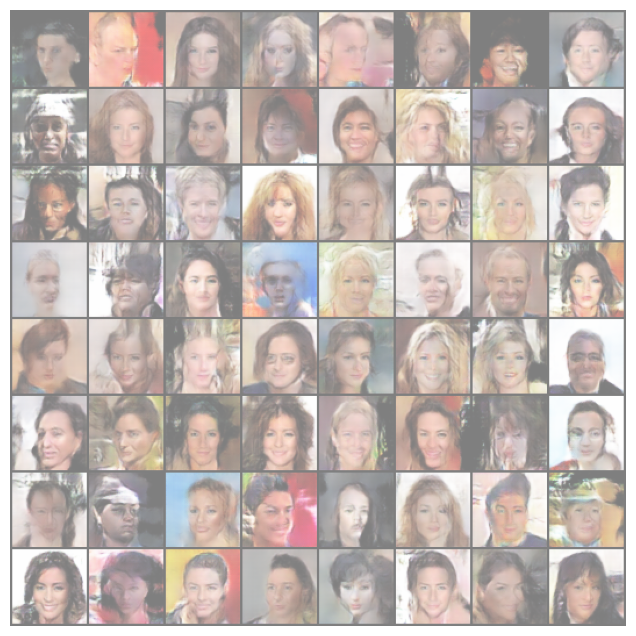

In [ ]:
imshow(img_list[-1])